## Wykład 7 Jak działa GPT?
### Architektura transformer

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [71]:
torch.set_printoptions(precision=2)

### Maskowana atencja
* ignorujemy na razie batch size
* w implementacji na laboratorium dochodzi jesze batch size jako pierwszy wymiar
* ale to nie zmienia wzorów i implemnetacji (chyba, że omówione dalej)

$$Q = X W_Q,\quad K = X W_K,\quad V = X W_V$$
$$\text{scores} = \frac{QK^{T}}{\sqrt{d_k}}$$
$$ M_{ij} = 
\begin{cases}
0 & \text{if } j \leq i \\
-\infty & \text{if } j > i
\end{cases}$$
$$\text{masked\_scores} = \text{scores} + M $$
$$\text{attention} = \text{softmax}\left(\text{masked\_scores}\right)$$
$$ \text{weighted\_values} = \text{attention} \cdot V $$
$$ out = \text{weighted\_values} \cdot W_{out} $$

In [72]:
seq_len = 4
d_model = 6
d_head = 2

In [73]:
# dane wejściowe
x = torch.randn(seq_len, d_model)
x

tensor([[ 0.19, -0.10, -0.68,  0.96, -3.06,  0.15],
        [ 1.54,  0.47,  0.41, -0.31,  0.74, -0.20],
        [ 1.83,  0.59,  0.02,  1.08, -0.55,  0.04],
        [-2.33,  0.80,  1.36,  0.30,  1.03,  1.59]])

Zapytania (quesries $Q$), klucze (keys $K$) i wartości (values $V$):
$$Q = X W_Q,\quad K = X W_K,\quad V = X W_V$$

In [74]:
Wk = nn.Linear(d_model, d_head, bias=False)
Wq = nn.Linear(d_model, d_head, bias=False)
Wv = nn.Linear(d_model, d_head, bias=False)

In [75]:
K = Wk(x)
Q = Wq(x)
V = Wv(x)
print(K.shape)

torch.Size([4, 2])


In [76]:
K

tensor([[-0.81, -0.61],
        [ 0.88,  0.52],
        [ 0.39,  0.39],
        [-0.64,  0.96]], grad_fn=<MmBackward0>)

Dzielenie przez $\sqrt{d_k}$ służy normalizacji (za duże wartości powodują, że większość prawdopodobieństwa po softmax jest przypisana do jednej wartości)
$$\text{scores} = \frac{QK^{T}}{\sqrt{d_k}}$$

In [77]:
# https://pytorch.org/docs/stable/generated/torch.transpose.html
# Returns a tensor that is a transposed version of input. The given dimensions dim0 and dim1 are swapped.
K.transpose(-2, -1)

tensor([[-0.81,  0.88,  0.39, -0.64],
        [-0.61,  0.52,  0.39,  0.96]], grad_fn=<TransposeBackward0>)

In [78]:
scores = Q @ K.transpose(-2, -1) * d_head ** (-0.5)
print(scores.shape)
print(scores)

torch.Size([4, 4])
tensor([[-1.13,  1.11,  0.63,  0.34],
        [ 0.01, -0.02,  0.00,  0.08],
        [-0.41,  0.39,  0.24,  0.28],
        [ 0.74, -0.69, -0.43, -0.58]], grad_fn=<MulBackward0>)


Celem stosowania maski jest pominięcie przyszłych elementów sekwencji w predykcji:

Maska:
$$ M_{ij} = 
\begin{cases}
0 & \text{if } j \leq i \\
-\infty & \text{if } j > i
\end{cases}$$

$$\text{masked\_scores} = \text{scores} + M $$

In [79]:
mask = torch.tril(torch.ones(seq_len, seq_len))
mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [80]:
masked_scores = scores.masked_fill(mask == 0, float('-inf'))
masked_scores

tensor([[-1.13,  -inf,  -inf,  -inf],
        [ 0.01, -0.02,  -inf,  -inf],
        [-0.41,  0.39,  0.24,  -inf],
        [ 0.74, -0.69, -0.43, -0.58]], grad_fn=<MaskedFillBackward0>)

Atencja:
$$\text{attention} = \text{softmax}\left(\text{masked\_scores}\right)$$

In [81]:
attention = F.softmax(masked_scores, dim=-1)
attention

tensor([[1.00, 0.00, 0.00, 0.00],
        [0.51, 0.49, 0.00, 0.00],
        [0.20, 0.43, 0.37, 0.00],
        [0.55, 0.13, 0.17, 0.15]], grad_fn=<SoftmaxBackward0>)

Bierzemy $V$ z wagami wyznaczonymi przez atencję
$$ \text{weighted\_values} = \text{attention} \cdot V $$

In [82]:
V

tensor([[-0.96, -0.47],
        [-0.36,  0.74],
        [-0.68,  0.48],
        [ 1.47, -0.28]], grad_fn=<MmBackward0>)

In [83]:
weighted_values = attention @ V
weighted_values

tensor([[-0.96, -0.47],
        [-0.66,  0.13],
        [-0.60,  0.41],
        [-0.47, -0.12]], grad_fn=<MmBackward0>)

Przekształcamy ponownie do rozmiaru *d_model*:
$$ out = \text{weighted\_values} \cdot W_{out} $$

In [84]:
Wout = nn.Linear(d_head, d_model, bias=False)

In [85]:
out = Wout(weighted_values)
out

tensor([[-0.05, -0.40,  0.36,  0.09, -0.54, -0.32],
        [-0.25, -0.52,  0.09, -0.08, -0.08, -0.32],
        [-0.36, -0.62, -0.02, -0.16,  0.11, -0.35],
        [-0.08, -0.26,  0.14,  0.01, -0.20, -0.18]], grad_fn=<MmBackward0>)

### Wymiary
* przetwarzamy dane wejściowe o kształcie rozmiar batcha x długość sekwencji
* potem wewnątrz modelu zamieniamy tokeny na reprezentację wektorową
* i przetwarzamy rozmiar batcha x *d_model* x długość sekwencji
* *d_model* to długość reprezentacji wektorowej dla tokenu

In [86]:
vocab_size = 5
batch_size = 2
seq_len = 3
d_model = 4

In [87]:
X = torch.randint(high=vocab_size, size=(batch_size, seq_len))
X

tensor([[2, 1, 2],
        [0, 1, 3]])

In [88]:
emb = nn.Embedding(vocab_size, d_model) 

In [89]:
x_emb = emb(X)
x_emb

tensor([[[ 2.02e-01, -5.13e-01, -1.71e-02,  1.46e+00],
         [-3.61e-01, -2.11e-01,  7.92e-01, -5.56e-01],
         [ 2.02e-01, -5.13e-01, -1.71e-02,  1.46e+00]],

        [[ 1.82e+00,  7.10e-01, -2.96e-01, -2.06e-01],
         [-3.61e-01, -2.11e-01,  7.92e-01, -5.56e-01],
         [ 8.35e-01,  1.03e-03,  6.03e-01,  2.18e+00]]],
       grad_fn=<EmbeddingBackward0>)

In [90]:
x_emb.shape

torch.Size([2, 3, 4])

#### Entropia krzyżowa w 3 wymiarach

In [91]:
y = torch.randint(high=vocab_size, size=(batch_size, seq_len))
y

tensor([[3, 2, 0],
        [4, 3, 4]])

In [92]:
logits = torch.randn(batch_size, seq_len, vocab_size)
logits

tensor([[[-0.48,  0.36, -0.80, -1.15,  0.37],
         [ 1.93, -0.66, -0.34,  0.20, -0.83],
         [-0.04,  1.48,  0.49,  1.09,  0.48]],

        [[-0.31, -1.18, -0.33,  0.49, -0.99],
         [ 1.13,  0.79, -0.95,  0.35, -0.61],
         [ 0.87, -0.82, -1.12, -0.32,  0.57]]])

In [93]:
F.cross_entropy(logits, y)

RuntimeError: Expected target size [2, 5], got [2, 3]

#### Entropia krzyżowa dla większej liczby wymiarów
https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

* Uwaga: prawdopodobieństwa (logity) muszą mieć wymiar liczba przykładów x liczba klas
* Przekształcamy logity do kształtu (batch_size * seq_len, vocab_size)
* A etykiety do kształtu (batch_size * seq_len)
* W ten sposób wyznaczamy predykcję i liczymy funkcję straty **dla każdego elementu sekwencji** (nie tylko ostatniego)

In [94]:
# do zmiany wymiaru używamy view
logits.view(batch_size * seq_len, vocab_size)

tensor([[-0.48,  0.36, -0.80, -1.15,  0.37],
        [ 1.93, -0.66, -0.34,  0.20, -0.83],
        [-0.04,  1.48,  0.49,  1.09,  0.48],
        [-0.31, -1.18, -0.33,  0.49, -0.99],
        [ 1.13,  0.79, -0.95,  0.35, -0.61],
        [ 0.87, -0.82, -1.12, -0.32,  0.57]])

In [95]:
logits.view(batch_size * seq_len, vocab_size).shape

torch.Size([6, 5])

In [96]:
loss = F.cross_entropy(logits.view(batch_size * seq_len, vocab_size), y.view(batch_size * seq_len)) # zmiana kształtu https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
loss

tensor(2.15)

### Module list i sumowanie wyjść

In [97]:
ml = nn.ModuleList([nn.Linear(2, 3) for i in range(4)])

In [98]:
ml

ModuleList(
  (0-3): 4 x Linear(in_features=2, out_features=3, bias=True)
)

In [99]:
ml[0]

Linear(in_features=2, out_features=3, bias=True)

In [100]:
x = torch.randn(2, 2)
x

tensor([[ 0.31,  2.03],
        [-1.00, -1.22]])

In [101]:
out = ml[0](x)
out

tensor([[-0.44,  0.08,  0.78],
        [ 0.88, -0.44,  0.02]], grad_fn=<AddmmBackward0>)

In [102]:
# stosujemy do x każdą warstwę i sumoujemy wyniki
for layer in ml[1:]:
    out += layer(x) 

In [103]:
out

tensor([[-1.16,  1.08,  1.47],
        [ 2.30,  0.71,  0.21]], grad_fn=<AddBackward0>)

### Kodowanie pozycyjne (positional embedding)
* Mechanizm atencji odpowiada za kopiowanie wartości podobnych (istotnych tokenów) do bieżącego tokenu
* Ale token nie ma **żadnej informacji** na jakiej pozycji w sekwencji się znajduje
* Rozwiązujemy to porzez dodanie **positional embedding** które koduje **pozycję tokenu**
* Uwaga! Na wejściu tego embeddingu nie ma danych wejściowych (tekstu, tokenów), tylko **numery polejne pozycji w sekwencji**

In [104]:
pos_emb = nn.Embedding(seq_len, d_model)

In [105]:
pos_emb

Embedding(3, 4)

In [6]:
torch.tensor([range(seq_len)])

tensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [106]:
pos_emb(torch.tensor([range(seq_len)]))

tensor([[[-0.95, -1.41, -0.92, -1.71],
         [-0.81,  0.15, -0.86,  0.17],
         [-0.85, -0.27, -1.34, -1.13]]], grad_fn=<EmbeddingBackward0>)

In [107]:
pos_emb(torch.tensor([range(seq_len)])).shape

torch.Size([1, 3, 4])

### Funkcja aktywacji GELU

In [108]:
gelu = nn.GELU()

In [109]:
x = torch.arange(-3, 3, 0.01)

In [110]:
x_gelu = gelu(x)

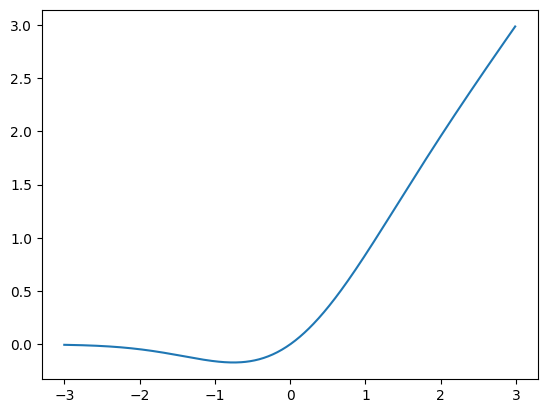

In [112]:
plt.plot(x, x_gelu);

### Umieszczanie warstw po sobie (nn.Sequential)

In [113]:
modules = nn.Sequential(nn.Linear(2, 3), nn.Linear(3, 4))

In [115]:
x = torch.randn(2, 2)
x

tensor([[-0.50,  2.73],
        [ 0.44,  0.37]])

In [116]:
modules(x)

tensor([[-0.98, -0.75, -0.46,  0.22],
        [ 0.53, -0.93,  0.63,  0.08]], grad_fn=<AddmmBackward0>)

### Layer Norm

---

### **1. What does `nn.LayerNorm` do?**

`nn.LayerNorm(d_model)` normalizes the input across the last dimension. For an input vector \$ x_i \in \mathbb{R}^{d_{\text{model}}}$, the LayerNorm output is computed as:


$$\text{LayerNorm}(x_i) = \gamma \cdot \frac{x_i - \mu_i}{\sqrt{\sigma_i^2 + \varepsilon}} + \beta$$

Where:

- $\mu_i = \frac{1}{d_{\text{model}}} \sum_{j=1}^{d_{\text{model}}} x_{ij}$ is the mean of the *i*-th row  
- $ \sigma_i^2 = \frac{1}{d_{\text{model}}} \sum_{j=1}^{d_{\text{model}}} (x_{ij} - \mu_i)^2$ is the variance (biased; divides by $ d_{\text{model}}$)  
- $ \varepsilon$ is a small constant for numerical stability  
- $\gamma$ and $\beta$ are learnable parameters (default: $\gamma = 1$, $\beta = 0$)

As a result, after applying LayerNorm, each row will have approximately zero mean and unit variance.

---

In [118]:
# layer norm na slajdy
ln = nn.LayerNorm(d_model)

In [119]:
x = torch.randn(2, d_model)
x

tensor([[ 0.09, -0.10, -0.03, -1.64],
        [ 0.26, -2.21,  0.19,  1.06]])

In [122]:
x_ln = ln(x)
x_ln

tensor([[ 0.72,  0.45,  0.55, -1.72],
        [ 0.35, -1.66,  0.30,  1.01]], grad_fn=<NativeLayerNormBackward0>)

In [123]:
x_ln.sum(axis=1)

tensor([-1.19e-07, -2.38e-07], grad_fn=<SumBackward1>)

In [127]:
x_ln.var(axis=1, unbiased=False)

tensor([1.00, 1.00], grad_fn=<VarBackward0>)

In [128]:
# gamma
ln.weight

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

In [129]:
# beta
ln.bias

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)